In [1]:
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as int
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm


#import Networkx as net
import Plot3D as plot3d
import dataframe as dataframe

#### Neural Ode

In [2]:
class Simple_FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_layers, depth, output_dim, activation_func=nn.Tanh()):
        super(Simple_FeedforwardNN, self).__init__()

        layers = []
        previous_depth = input_dim
        for _ in range(hidden_layers):
            layers.append(nn.Linear(previous_depth, depth))
            layers.append(activation_func)
            previous_depth = depth

        layers.append(nn.Linear(depth, output_dim))
        self.network = nn.Sequential(*layers)

        #Setting initial weights
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.2)
                nn.init.constant_(m.bias, val=0)

class auto_neural_ode(Simple_FeedforwardNN):
    def __init__(self, variables, hidden_layers=1, depth_of_layers=10):
            super().__init__(input_dim=variables,
                            hidden_layers=hidden_layers,
                            depth=depth_of_layers,
                            output_dim=variables,
                            activation_func=nn.Tanh() )
            
            self.depth              = depth_of_layers #Depth is number of neurons per hidden layer
            self.hiddenlayers       = hidden_layers #Number of internal hidden layers
            self.variables          = variables
    
    def forward(self, t, x):
        output = self.network(x)
        return output
         



#### Generating Data

##### Models

In [3]:
class SaddleNodeStable:
    def __init__(self, a, b, r):
        #Setting system parameters
        self.a = a
        self.r = r
        self.b = b

    #Differential Equation
    def f(self, t, x):
        xdot = -(x-self.a)*((x-self.b)**2 + self.r(t) )

        return np.array(xdot)

In [4]:
def parameter_f(t):
        if t <= 5.0: 
                return -0.5
        elif t > 5.0:
                return 1
   

In [5]:
saddlenode = SaddleNodeStable(a = 0.1, b = 1, r = parameter_f)

##### Solving IVP

In [236]:
init = 1 + np.sqrt(0.5)

In [237]:

dt = 0.01; tfinal = 10; tstart = 0
t_eval = np.arange(tstart, tfinal, dt)

In [238]:
output = int.solve_ivp(saddlenode.f, t_span=(tstart, tfinal), y0=[1.0],
                        method = 'RK45', t_eval = t_eval)
data1 = output.y


##### Plotting

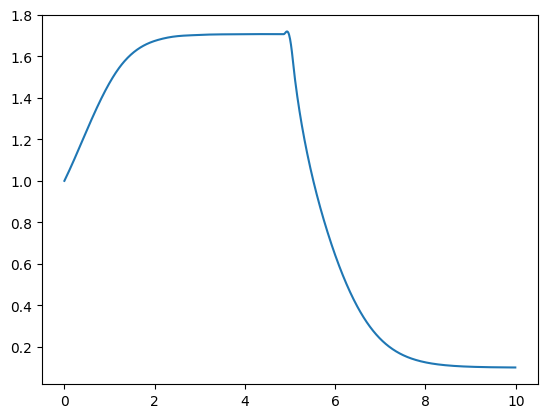

In [240]:
plt.plot(np.arange(tstart, tfinal, dt), data1.squeeze())



##### Batching

In [241]:
def batch(data, t, batch_length, batch_size):
    data_length = data.shape[0]
    indices = np.random.randint(0, data_length - batch_length, batch_size)
    batch_list = []
    batch_time_list = []

    for i in range(0, batch_size):
        batch_list.append(data[indices[i]:indices[i]+batch_length, :].float())
        batch_time_list.append(t[indices[i]:indices[i]+batch_length].float().requires_grad_(True))

    return batch_list, batch_time_list
        
data1_tensor = torch.tensor(data1)
t_eval_tensor = torch.tensor(t_eval)


#### Training:

##### Setting Parameters

In [7]:
#Setting model, optimiser and loss
def parameter_f(t):
        if t <= 5.0: 
                return torch.tensor(-0.5)
        elif t > 5.0:
                return torch.tensor(1)
        
model1 = auto_neural_ode(variables=1, hidden_layers=2, depth_of_layers=15)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
loss_fn = nn.MSELoss()




In [8]:
x = torch.tensor([1], dtype=torch.float32)
t = torch.tensor([0], dtype=torch.float32)
print(model1.network)
model1(t=t, x=x)

Sequential(
  (0): Linear(in_features=1, out_features=15, bias=True)
  (1): Tanh()
  (2): Linear(in_features=15, out_features=15, bias=True)
  (3): Tanh()
  (4): Linear(in_features=15, out_features=1, bias=True)
)


tensor([0.2000], grad_fn=<ViewBackward0>)

In [13]:
model1._parameters

{}

##### Training Loop: Set 1

In [244]:
data_set1 = data1_tensor[:, 0:500]
t_eval_set1 = t_eval_tensor[0:500]
batch_list, batch_time_list = batch(data_set1.T, t_eval_set1, batch_length=80, batch_size=5)

In [245]:
loss_list_set1 = []
batch_length = 80; batch_size = 5

In [246]:
num_epochs = 1000
for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(data_set1.T, t_eval_set1, batch_length=batch_length, batch_size=batch_size)
    for i in range(0, batch_size):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
        pred_x = odeint(model1 , batch_i[0].unsqueeze(0), batch_time_i, method='rk4', options={'step_size': 0.01})

        #Calculating loss
        loss = loss_fn(pred_x.squeeze(1), torch.tensor(batch_i))
        #loss_list.append(loss.item())

        #batch_time_i.retain_grad()
        #Backpropagation
        loss.backward()
        optimizer.step()
        #tgrad_list.append(torch.mean(abs(batch_time_i.grad)).item())
    
    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                pred_x = odeint(model1, torch.tensor(init, dtype=torch.float32).unsqueeze(0).unsqueeze(1), t_eval_set1, method='rk4', options={'step_size': 0.01})
                train_loss = loss_fn(pred_x.squeeze(1), data_set1.T)
                loss_list_set1.append(train_loss.item())
                #print(f"Epoch: {epoch}  training loss {train_loss.item()}")  

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\jackr\AppData\Local\Temp\ipykernel_23912\4033410603.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(pred_x.squeeze(1), torch.tensor(batch_i))
  0%|          | 1/1000 [00:05<1:24:36,  5.08s/it]

Epoch 0, Loss: 0.18481873959868125


 10%|█         | 101/1000 [04:11<40:35,  2.71s/it]

Epoch 100, Loss: 0.18481873959868125


 20%|██        | 201/1000 [08:25<36:11,  2.72s/it]

Epoch 200, Loss: 0.18481873959868125


 30%|███       | 301/1000 [12:36<31:05,  2.67s/it]

Epoch 300, Loss: 0.18481873959868125


 40%|████      | 401/1000 [16:43<25:59,  2.60s/it]

Epoch 400, Loss: 0.18481873959868125


 50%|█████     | 501/1000 [20:48<21:44,  2.61s/it]

Epoch 500, Loss: 0.18481873959868125


 60%|██████    | 601/1000 [24:59<17:47,  2.67s/it]

Epoch 600, Loss: 0.18481873959868125


 70%|███████   | 701/1000 [29:15<13:10,  2.64s/it]

Epoch 700, Loss: 0.18481873959868125


 80%|████████  | 801/1000 [33:27<08:43,  2.63s/it]

Epoch 800, Loss: 0.18481873959868125


 90%|█████████ | 901/1000 [37:41<04:30,  2.73s/it]

Epoch 900, Loss: 0.18481873959868125


100%|██████████| 1000/1000 [41:53<00:00,  2.51s/it]


In [247]:
##### Setting Parameters

In [248]:

#Setting model, optimiser and loss
def parameter_f(t):
        if t <= 5.0: 
                return torch.tensor(-0.5)
        elif t > 5.0:
                return torch.tensor(1)
        
model2 = auto_neural_ode(variables=1, hidden_layers=2, depth_of_layers=15)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
loss_fn = nn.MSELoss()



x = torch.tensor([1], dtype=torch.float32)
t = torch.tensor([0], dtype=torch.float32)
print(model2.network)
model2(t=t, x=x)

Sequential(
  (0): Linear(in_features=1, out_features=15, bias=True)
  (1): Tanh()
  (2): Linear(in_features=15, out_features=15, bias=True)
  (3): Tanh()
  (4): Linear(in_features=15, out_features=1, bias=True)
)


tensor([0.0605], grad_fn=<ViewBackward0>)

##### Training Loop: Set 2 

In [249]:
data_set2 = data1_tensor[:, 500:1000]
t_eval_set2 = t_eval_tensor[500:1000]
batch_list, batch_time_list = batch(data_set2.T, t_eval_set2, batch_length=80, batch_size=5)

In [250]:
loss_list_set2 = []
batch_length = 80; batch_size = 5

In [251]:
num_epochs = 1000
for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(data_set2.T, t_eval_set2, batch_length=batch_length, batch_size=batch_size)
    for i in range(0, batch_size):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
        pred_x = odeint(model2, batch_i[0].unsqueeze(0), batch_time_i, method='rk4', options={'step_size': 0.01})

        #Calculating loss
        loss = loss_fn(pred_x.squeeze(1), torch.tensor(batch_i))
        #loss_list.append(loss.item())

        #batch_time_i.retain_grad()
        #Backpropagation
        loss.backward()
        optimizer.step()
        #tgrad_list.append(torch.mean(abs(batch_time_i.grad)).item())
    
    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                pred_x = odeint(model2, torch.tensor(init, dtype=torch.float32).unsqueeze(0).unsqueeze(1), t_eval_set2, method='rk4', options={'step_size': 0.01})
                train_loss = loss_fn(pred_x.squeeze(1), data_set2.T)
                loss_list_set2.append(train_loss.item())
                #print(f"Epoch: {epoch}  training loss {train_loss.item()}")  

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\jackr\AppData\Local\Temp\ipykernel_23912\61102690.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_fn(pred_x.squeeze(1), torch.tensor(batch_i))
  0%|          | 1/1000 [00:03<58:00,  3.48s/it]

Epoch 0, Loss: 2.1060928703414348


 10%|█         | 101/1000 [05:34<49:25,  3.30s/it] 

Epoch 100, Loss: 0.0013964373959174479


 20%|██        | 201/1000 [10:48<39:56,  3.00s/it]

Epoch 200, Loss: 0.0009396440597215615


 30%|███       | 301/1000 [15:51<38:18,  3.29s/it]

Epoch 300, Loss: 0.0007033553241306497


 40%|████      | 401/1000 [20:41<29:59,  3.00s/it]

Epoch 400, Loss: 0.0005301980381162851


 50%|█████     | 501/1000 [25:50<25:49,  3.10s/it]

Epoch 500, Loss: 0.0012027433807040033


 60%|██████    | 601/1000 [31:00<21:12,  3.19s/it]

Epoch 600, Loss: 0.0005067197391958325


 70%|███████   | 701/1000 [35:26<06:40,  1.34s/it]

Epoch 700, Loss: 0.0005792732942278846


 80%|████████  | 801/1000 [37:33<04:26,  1.34s/it]

Epoch 800, Loss: 0.00039821574255116953


 90%|█████████ | 901/1000 [39:56<02:35,  1.57s/it]

Epoch 900, Loss: 0.0004546347712378132


100%|██████████| 1000/1000 [42:25<00:00,  2.55s/it]


##### Loss Plots


#### Plotting Results 

In [ ]:
pred_x1 = odeint(model1, torch.tensor(2, dtype=torch.float32).unsqueeze(0).unsqueeze(1), t_eval_set1, method='rk4', options={'step_size': 0.01})
pred_x2 = odeint(model2, torch.tensor(pred_x1[-1, 0, 0], dtype=torch.float32).unsqueeze(0).unsqueeze(1), t_eval_set2, method='rk4', options={'step_size': 0.01})

In [292]:
output = np.concatenate((pred_x1.detach().numpy()[:, :, 0], pred_x2.detach().numpy()[:, :, 0]), axis=0)

In [286]:
output = int.solve_ivp(saddlenode.f, t_span=(tstart, tfinal), y0=[2.0],
                        method = 'RK45', t_eval = t_eval)
data1 = output.y

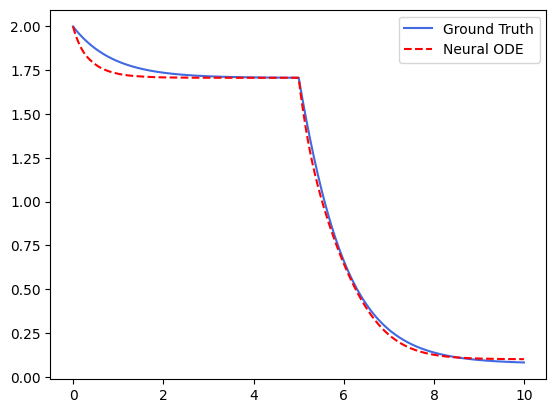

In [ ]:
plt.plot(t_eval, output[:, 0], color='royalblue', label = 'Ground Truth')
plt.plot(t_eval, data1[0, :], color='r', linestyle='--', label='Neural ODE')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

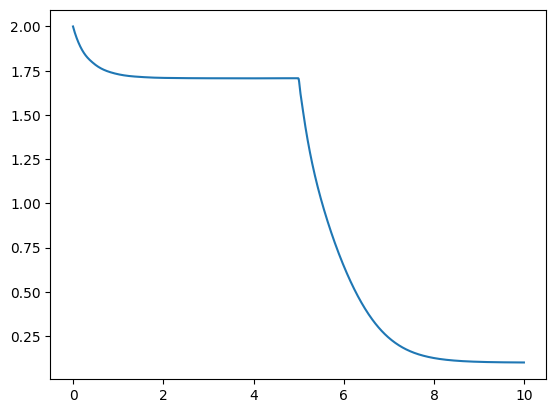

In [ ]:
plt.plot(t_eval, data1[0, :])